# Unified Data Layers
*Original author: Sina Kashuk, modified by Dahn Jahn*

This notebook uses the [H3-Pandas](https://github.com/DahnJ/H3-Pandas) API to simplify [uber/h3-py-notebooks/notebooks/unified_data_layers.ipynb](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

### Summary: 
One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms. In this tutorial we are going through an example of how to bring the US census data, NYC 311 Noise complaints, and Digital Elevation Model to the hexagon aperture and then how to visualize the data to gain insight.

### Data
* **POLYGON:** Census Tract Data [[Source]](https://www.census.gov/data.html)
* **POINT:** NYC 311 noise complaints [[Source]](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/7ahn-ypff)
* **RASTER:** NYC Digital Elevation Model [[Source]](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-Integer-Raster/7kuu-zah7/)

pip install h3pandas

In [ ]:
import pandas as pd
import geopandas as gpd
import h3pandas
import matplotlib.pyplot as plt

## Load data

In [2]:
# modified data link
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
nyc_dem_link = 'https://gist.githubusercontent.com/DahnJ/5b77a1d7047412e35e0c1f9ff10ea182/raw/b328c6beb369127081287ac2a17820280d35898b/dem_nyc_xyz.csv'

In [3]:
METRIC_COL = 'SE_T002_002' # population density
INDEX_COL = 'BoroCT2010'

### Load 311 noise complaints

In [4]:
df311 = pd.read_csv(noise_311_link)

### Load Census Tract data

In [5]:
gdf = gpd.read_file(ct_shape_link).drop(columns='gdf').astype({INDEX_COL: str}).set_index(INDEX_COL)

In [6]:
df = pd.read_csv(ct_data_link, usecols=[INDEX_COL,METRIC_COL], dtype={INDEX_COL: str}).set_index(INDEX_COL)

gdf = gdf.join(df)
gdf[METRIC_COL] = gdf[METRIC_COL].fillna(0)
gdf = gdf.loc[~gdf.geometry.isna()]

### Load DEM

In [7]:
df_dem = pd.read_csv(nyc_dem_link)

## Point to hex

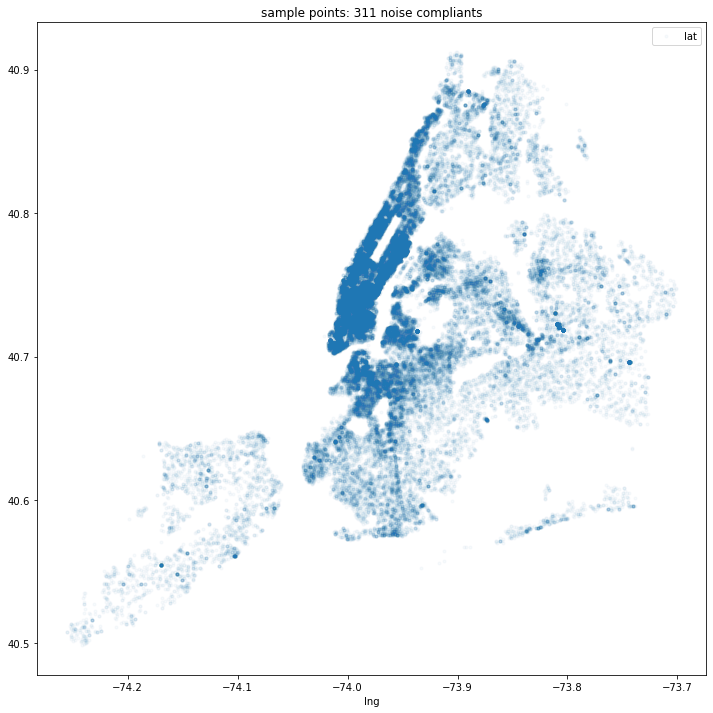

In [8]:
# Visualize the 311 noise complaints points
df311.plot(x='lng',y='lat',style='.',alpha=0.03,figsize=(12,12));
plt.title('sample points: 311 noise compliants');

In [9]:
APERTURE_SIZE = 9

In [10]:
df311 = (df311
 .assign(count=1)
 .h3.geo_to_h3_aggregate(APERTURE_SIZE))

Text(0.5, 1.0, 'hex-grid: noise complaints')

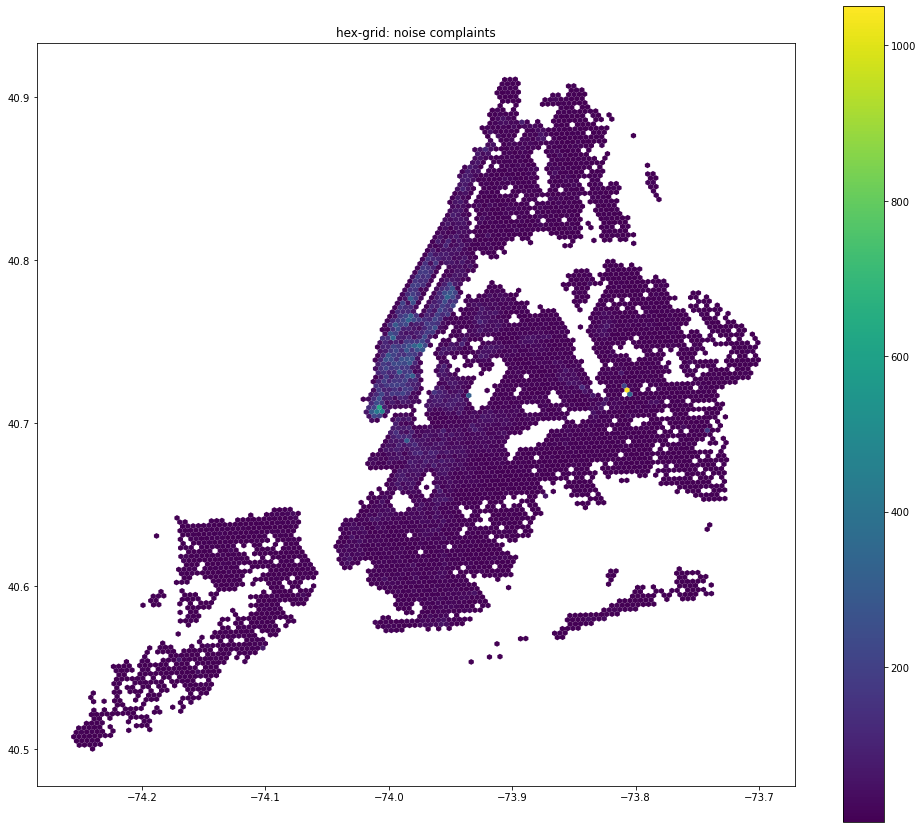

In [11]:
df311.plot(figsize=(17, 15), column='count', cmap='viridis', edgecolor='none', legend=True)
plt.title('hex-grid: noise complaints')

## Spatial smoothing

In [12]:
k = 2

In [13]:
df311s = df311.h3.k_ring_smoothing(k).h3.h3_to_geo_boundary()

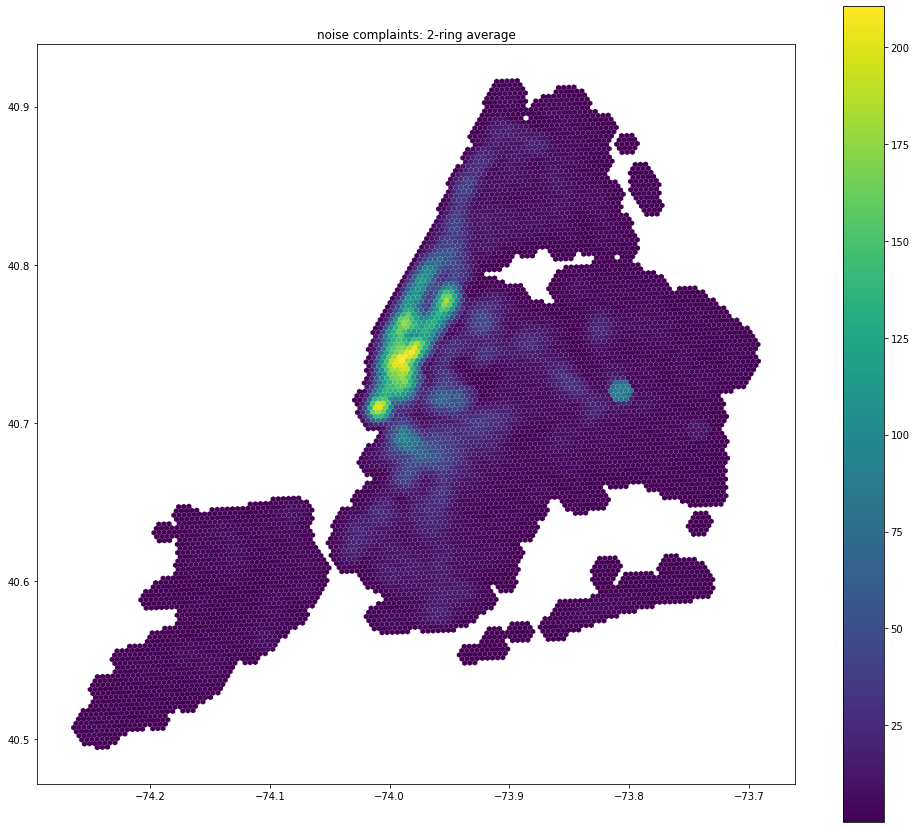

In [14]:
df311s.plot(figsize=(17, 15), column='count', cmap='viridis', edgecolor='none', legend=True)
plt.title('noise complaints: 2-ring average');

## Visualize Census Tract polygons

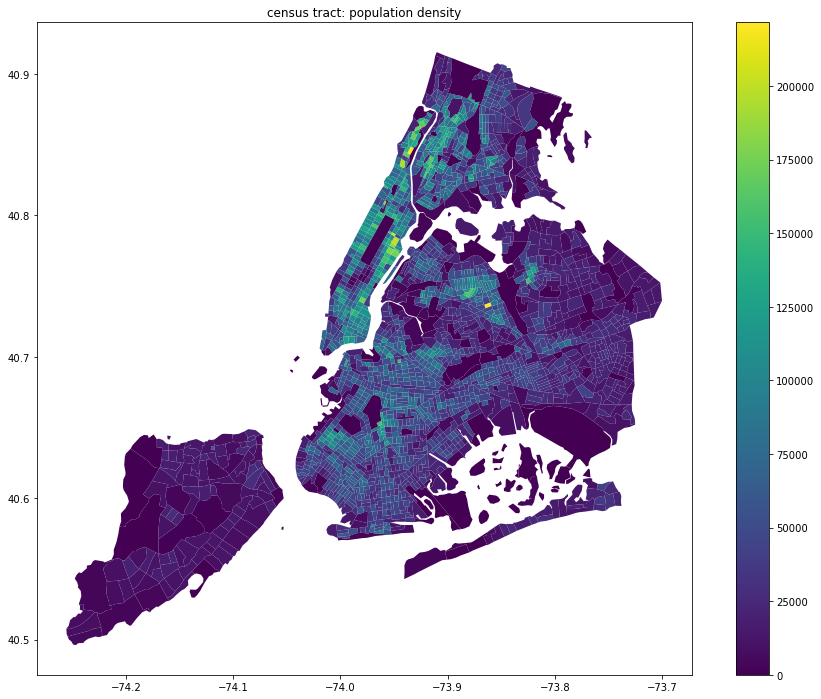

In [15]:
gdf.plot(column=METRIC_COL, cmap='viridis', linewidth=0.05, figsize=(16, 12), legend=True)
plt.title('census tract: population density');

## Census polygon to hex

In [16]:
APERTURE_SIZE=10
dfh = gdf.h3.polyfill_resample(APERTURE_SIZE)

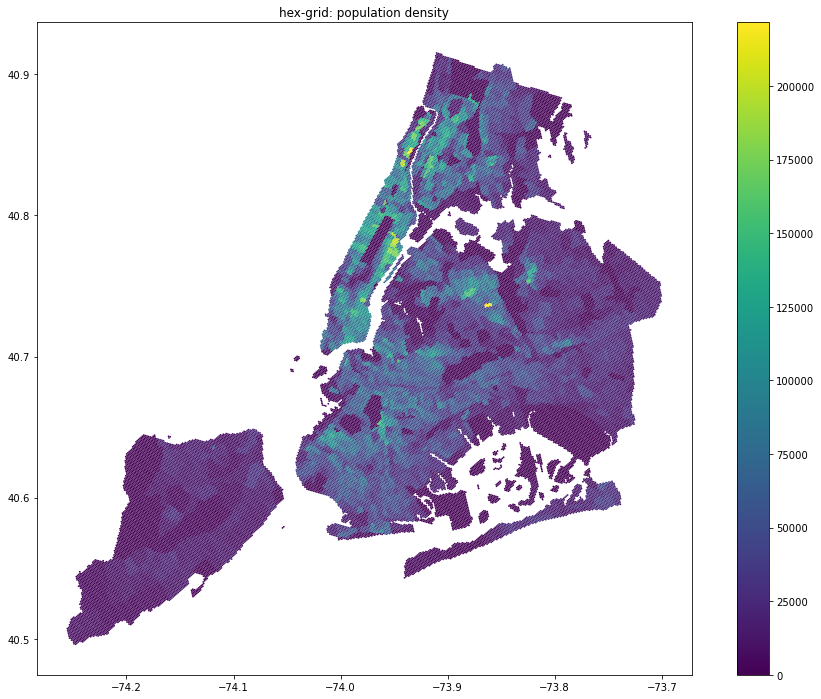

In [17]:
dfh.plot(figsize=(16, 12), column=METRIC_COL, legend=True)
plt.title('hex-grid: population density');

## Spatial weighted smoothing

In [18]:
coef = [1, .8, .4, .15, 0.05]

In [19]:
df_ct_kw = dfh.h3.k_ring_smoothing(weights=coef)

Text(0.5, 1.0, 'hex-grid: smoothed population density')

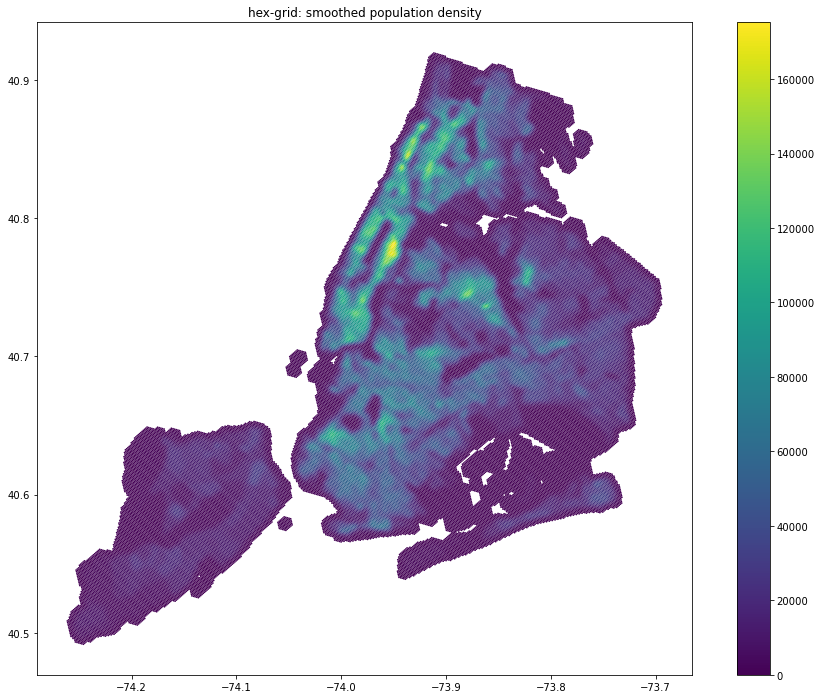

In [20]:
df_ct_kw.plot(figsize=(16, 12), column=METRIC_COL, legend=True)
plt.title('hex-grid: smoothed population density')

## Hierarchical re-sampling

### Resolution 9

In [21]:
df_coarse = df_ct_kw.h3.h3_to_parent_aggregate(9, 'mean')

Text(0.5, 1.0, 'hex-grid: population density')

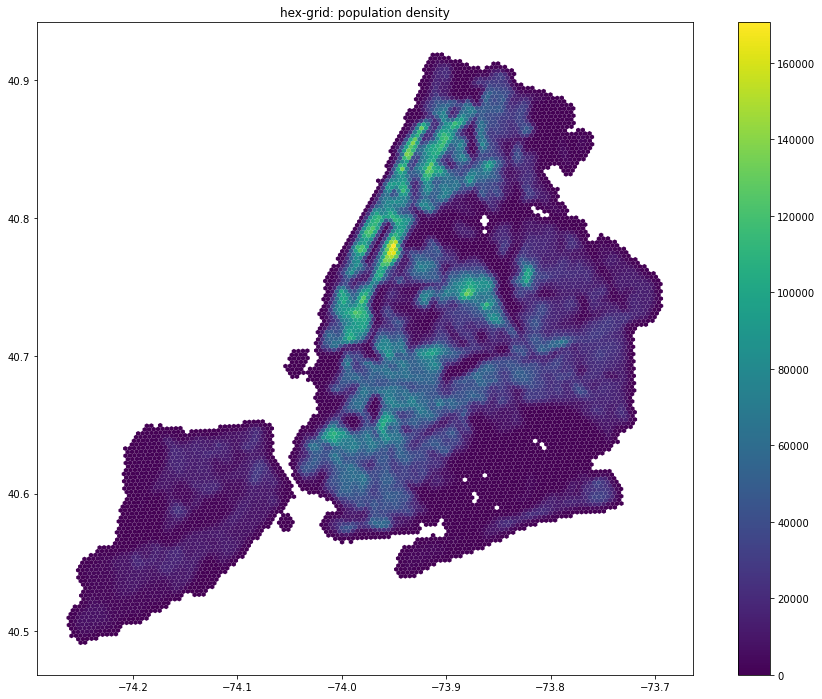

In [22]:
df_coarse.plot(figsize=(16, 12), column=METRIC_COL, legend=True)
plt.title('hex-grid: population density')

### Resolution 8

Text(0.5, 1.0, 'hex-grid: population density')

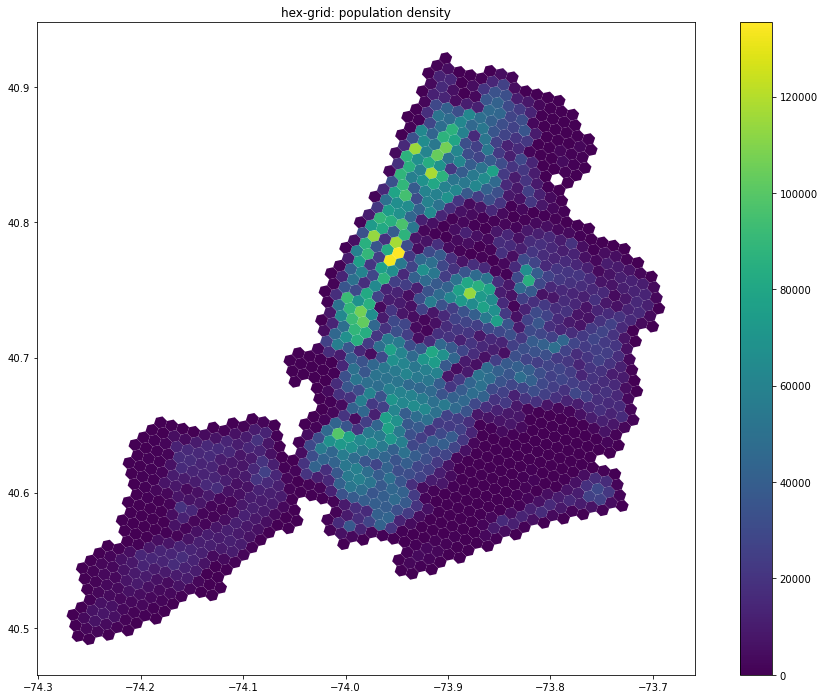

In [23]:
df_coarse.h3.h3_to_parent_aggregate(8, 'mean').plot(figsize=(16, 12), column=METRIC_COL, legend=True)
plt.title('hex-grid: population density')

## Raster to hex

In [24]:
df_dem = df_dem.h3.geo_to_h3_aggregate(9, 'mean')

Text(0.5, 1.0, 'hex-grid: elevation')

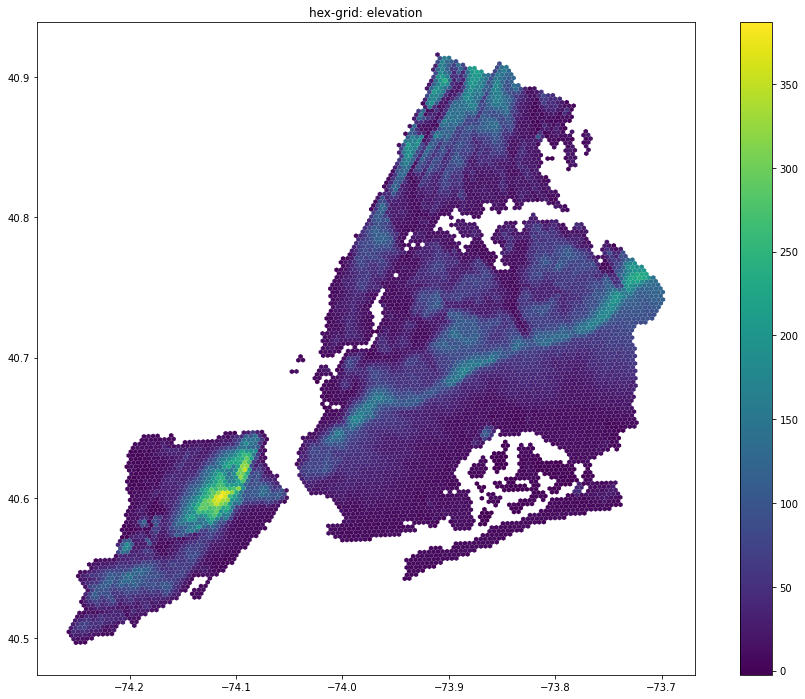

In [25]:
df_dem.plot(figsize=(16, 12), column='elevation', legend=True)
plt.title('hex-grid: elevation')

## Unifying data layers

In [26]:
dfu = (df_dem
       .join(df311s.drop(columns='geometry'))
       .join(df_coarse.drop(columns='geometry'))
       .rename(columns={METRIC_COL: "population","count":"noise_complaints"}))

,elevation,noise_complaints,population
count,8047.000000,7343.000000,8047.000000
mean,48.874082,13.281937,24833.451017
std,49.145254,26.843631,25614.949764
min,-2.473003,0.052632,0.000000
25%,13.088472,2.000000,5397.794072
50%,32.209505,4.315789,16142.488019
75%,67.886977,11.315789,37885.947293
max,386.767609,210.578947,170595.715931


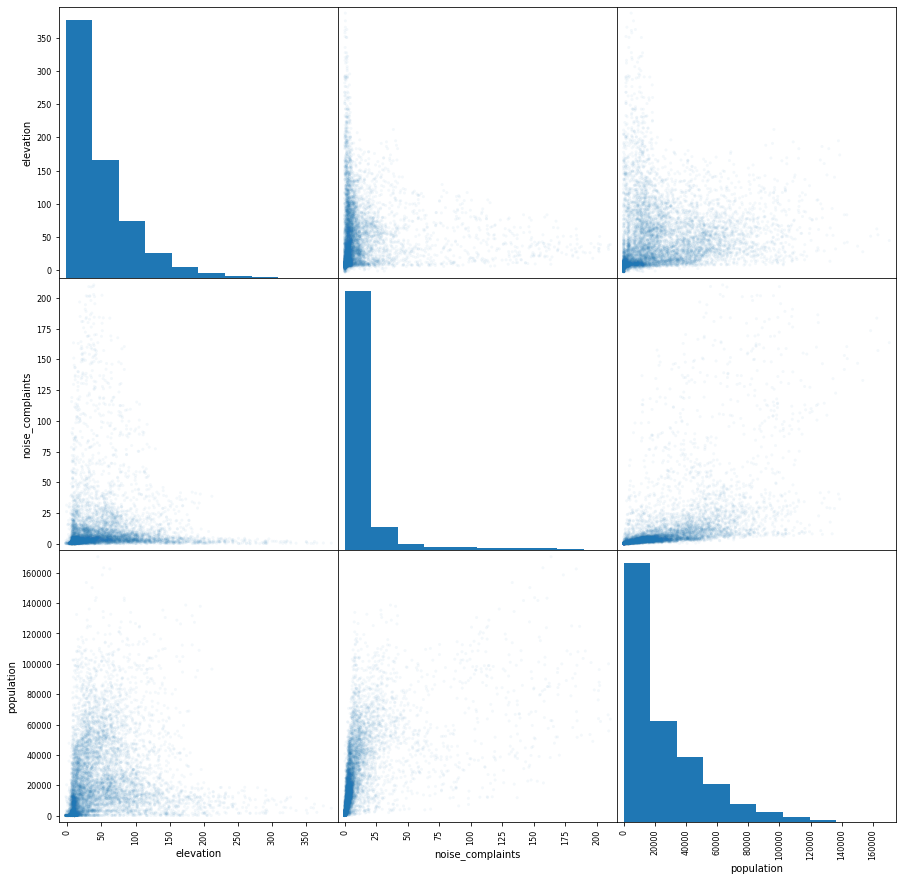

In [27]:
pd.plotting.scatter_matrix(dfu, alpha=0.05,figsize=(15,15));
dfu.describe()